In [42]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## MLOps Zoomcamp - 01-intro - Homework
https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2023/01-intro/homework.md

### Helper Functions

In [3]:
def getDataframe(filepath):
    '''
    
    '''
    # Read in parquet file
    df = pd.read_parquet(filepath)
    # Transform series using pd.to_datetime
    df['tpep_dropoff_datetime'] = pd.to_datetime(df.tpep_dropoff_datetime)
    df['tpep_pickup_datetime'] = pd.to_datetime(df.tpep_pickup_datetime)
    # Create col 'duration'
    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    # Transform 'duration' col into minutes
    df['duration'] = df['duration'].apply(lambda x: x.total_seconds() / 60)
    # Filter df so that duration was between 1 and 60 minutes (inclusive)
    df = df[((df.duration >= 1) & (df.duration <= 60))]
    categorical = ['PULocationID', 'DOLocationID']
    # Transforming categorical col values into strings
    df[categorical] = df[categorical].astype(str)  
    return df
    

### Q1. Downloading the data

In [4]:
ytaxi_raw_jan = pd.read_parquet("../data/yellow_tripdata_2022-01.parquet")

In [5]:
ytaxi_raw_jan

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


In [6]:
print(f'The data for January has {ytaxi_raw_jan.shape[1]} columns')

The data for January has 19 columns


### Q2. Computing duration

In [7]:
# Check columns within df
ytaxi_raw_jan.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [8]:
# Check dtypes within of cols
ytaxi_raw_jan.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [9]:
# Check type of dtype of dropoff and pickup cols
print(f'dropoff col type: {ytaxi_raw_jan["tpep_dropoff_datetime"].dtype }')
print(f'pickup col type: {type(ytaxi_raw_jan["tpep_pickup_datetime"][0])}')

dropoff col type: datetime64[ns]
pickup col type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [10]:
# Transform series using pd.to_datetime
ytaxi_raw_jan['tpep_dropoff_datetime'] = pd.to_datetime(ytaxi_raw_jan.tpep_dropoff_datetime)
ytaxi_raw_jan['tpep_pickup_datetime'] = pd.to_datetime(ytaxi_raw_jan.tpep_pickup_datetime)

In [11]:
print(f'dropoff col type: {ytaxi_raw_jan["tpep_dropoff_datetime"].dtype }')
print(f'pickup col type: {type(ytaxi_raw_jan["tpep_pickup_datetime"][0])}')

dropoff col type: datetime64[ns]
pickup col type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [12]:
# Create col 'duration'
ytaxi_raw_jan['duration'] = ytaxi_raw_jan['tpep_dropoff_datetime'] - ytaxi_raw_jan['tpep_pickup_datetime']

In [13]:
# Transform 'duration' col into minutes
ytaxi_raw_jan['duration'] = ytaxi_raw_jan['duration'].apply(lambda x: x.total_seconds() / 60)

In [14]:
# Get standard deviation of trip duration for January
description_jan = ytaxi_raw_jan['duration'].describe()
std_jan = round(description_jan.loc['std'], 2)
print(f'std for trip duration is: {std_jan}')

std for trip duration is: 46.45


### Q3. Dropping outliers

In [15]:
# Filter df so that duration was between 1 and 60 minutes (inclusive)
ytaxi_filtered_jan = ytaxi_raw_jan[((ytaxi_raw_jan.duration >= 1) & (ytaxi_raw_jan.duration <= 60))]

In [16]:
# What fraction of the records left after you dropped the outliers?
print(f'Raw df shape: {ytaxi_raw_jan.shape}')
print(f'Dropped outliers df shape: {ytaxi_filtered_jan.shape}')
left_frac = round((ytaxi_filtered_jan.shape[0] * 100) / ytaxi_raw_jan.shape[0])
print(f'Left fraction: {left_frac}')

Raw df shape: (2463931, 20)
Dropped outliers df shape: (2421440, 20)
Left fraction: 98


### Q4. One-hot encoding

In [17]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [18]:
# Transforming categorical col values into strings
ytaxi_filtered_jan[categorical] = ytaxi_filtered_jan[categorical].astype(str)

In [19]:
ytaxi_filtered_jan[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [20]:
train_dict = ytaxi_filtered_jan[categorical].to_dict(orient='records')

In [21]:
train_dict[:10]

[{'PULocationID': '142', 'DOLocationID': '236'},
 {'PULocationID': '236', 'DOLocationID': '42'},
 {'PULocationID': '166', 'DOLocationID': '166'},
 {'PULocationID': '114', 'DOLocationID': '68'},
 {'PULocationID': '68', 'DOLocationID': '163'},
 {'PULocationID': '138', 'DOLocationID': '161'},
 {'PULocationID': '233', 'DOLocationID': '87'},
 {'PULocationID': '238', 'DOLocationID': '152'},
 {'PULocationID': '166', 'DOLocationID': '236'},
 {'PULocationID': '236', 'DOLocationID': '141'}]

In [22]:
dv = DictVectorizer()

In [23]:
X_train = dv.fit_transform(train_dict)

In [24]:
X_train

<2421440x515 sparse matrix of type '<class 'numpy.float64'>'
	with 4842880 stored elements in Compressed Sparse Row format>

The dimensionality/number of cols of the matrix is 515.

### Q5. Training the model

In [25]:
# Define target variable
target = "duration"
y_train = ytaxi_filtered_jan[target].values

In [26]:
y_train

array([17.81666667,  8.4       ,  8.96666667, ..., 11.        ,
       12.05      , 27.        ])

In [27]:
# create model instance and fit the model
linr = LinearRegression()
linr.fit(X_train, y_train)

LinearRegression()

In [28]:
y_pred = linr.predict(X_train)

<ipython-input-29-8cbec3114a2e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="prediction")
<ipython-input-29-8cbec3114a2e>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label="ground_truth")


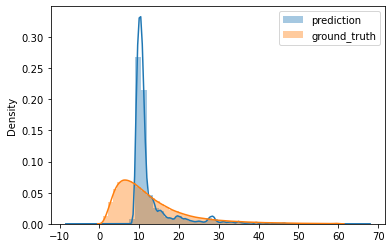

In [29]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="ground_truth")
plt.legend()

In [30]:
rmse = round(mean_squared_error(y_train, y_pred, squared=False),2)

In [31]:
print(f'The RMSE on train is {rmse}')

The RMSE on train is 6.99


### Q6. Evaluatig the model

In [32]:
ytaxi_raw_feb = getDataframe("../data/yellow_tripdata_2022-02.parquet")

In [33]:
ytaxi_raw_feb

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-02-01 00:06:58,2022-02-01 00:19:24,1.0,5.40,1.0,N,138,252,1,17.00,1.75,0.5,3.90,0.00,0.3,23.45,0.0,1.25,12.433333
1,1,2022-02-01 00:38:22,2022-02-01 00:55:55,1.0,6.40,1.0,N,138,41,2,21.00,1.75,0.5,0.00,6.55,0.3,30.10,0.0,1.25,17.550000
2,1,2022-02-01 00:03:20,2022-02-01 00:26:59,1.0,12.50,1.0,N,138,200,2,35.50,1.75,0.5,0.00,6.55,0.3,44.60,0.0,1.25,23.650000
3,2,2022-02-01 00:08:00,2022-02-01 00:28:05,1.0,9.88,1.0,N,239,200,2,28.00,0.50,0.5,0.00,3.00,0.3,34.80,2.5,0.00,20.083333
4,2,2022-02-01 00:06:48,2022-02-01 00:33:07,1.0,12.16,1.0,N,138,125,1,35.50,0.50,0.5,8.11,0.00,0.3,48.66,2.5,1.25,26.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2979426,2,2022-02-28 23:50:00,2022-03-01 00:06:00,NaN,3.40,NaN,None,163,193,0,14.37,0.00,0.5,0.00,0.00,0.3,17.67,NaN,NaN,16.000000
2979427,2,2022-02-28 23:06:57,2022-02-28 23:19:12,NaN,3.48,NaN,None,141,4,0,14.51,0.00,0.5,2.00,0.00,0.3,19.81,NaN,NaN,12.250000
2979428,2,2022-02-28 23:48:13,2022-03-01 00:03:33,NaN,3.05,NaN,None,161,151,0,14.38,0.00,0.5,3.81,0.00,0.3,21.49,NaN,NaN,15.333333
2979429,2,2022-02-28 23:56:41,2022-03-01 00:04:57,NaN,2.62,NaN,None,141,226,0,12.53,0.00,0.5,1.71,0.00,0.3,17.54,NaN,NaN,8.266667


In [34]:
val_dict = ytaxi_raw_feb[categorical].to_dict(orient='records')

In [36]:
X_val = dv.transform(val_dict)

In [37]:
# Define target variable
target = "duration"
y_val = ytaxi_raw_feb[target].values

In [38]:
# Predict on val set using trained model
y_pred = linr.predict(X_val)

In [39]:
rmse = round(mean_squared_error(y_val, y_pred, squared=False),2)

In [41]:
print(f'The RMSE on train is {rmse}')

The RMSE on train is 7.79


#### Saving Model

In [44]:
with open('./models/lin_reg.bin') as f:
    pkl.dump((dv,linr), f)

FileNotFoundError: [Errno 2] No such file or directory: './models/lin_reg.bin'